In [1]:
import numpy as np
import pandas as pd
import scipy as sp
import emcee 

from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import cross_val_score, LeaveOneOut, ShuffleSplit
from sklearn.preprocessing import FunctionTransformer, RobustScaler, MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.compose import TransformedTargetRegressor

from scipy import stats

from math import *
import sys
import re
import os
from itertools import chain

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

from tqdm import tqdm_notebook as tqdm

In [2]:
np.random.seed(0) # for reproducibility 

In [3]:
import seaborn as sns
sns.set(style="ticks", palette="muted", rc={"xtick.bottom" : True, "ytick.left" : True})
plt.style.use('matplotlibrc')
plt.rcParams['image.cmap']='viridis'

In [4]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
DF = pd.read_table('../regression/classical/models_rrab.dat', sep='\t')
DF.drop(columns=['Mode'], inplace=True)
DF = DF[DF['M'] < 9]
pd.set_option('display.max_columns', 500)

DF['Period'] = np.log10(DF['Period'])
DF.rename(columns={'Period':'logP'}, inplace=True)

DF['W']  = DF['I_M0'] - 1.55 * (DF['V_M0'] - DF['I_M0'])
DF['VI'] = DF['V_M0'] - DF['I_M0']

DF['logR'] = np.log10(np.sqrt(10**DF['logL']) * (DF['Teff']/5777)**-2)

# five models apparently failed to produce correct periods; let's drop them 
DF = DF.drop(np.argmin(DF['logP']))
DF = DF.drop(np.argmin(DF['logP']))
DF = DF.drop(np.argmin(DF['logP']))
DF = DF.reset_index(drop=True)

DF = DF[np.logical_not(np.logical_and(DF['logP'] > 0.1, DF['logR'] < 0.8))]
DF = DF.reset_index(drop=True)

print(DF.columns)
DF

Index(['M', 'Y', 'Z', 'logR', 'logL', 'Teff', 'logP', 'I_Amplitude',
       'I_Skewness', 'I_acuteness', 'I_R21', 'I_R31', 'I_M0', 'I_A1', 'I_A2',
       'I_A3', 'V_Amplitude', 'V_Skewness', 'V_acuteness', 'V_R21', 'V_R31',
       'V_M0', 'V_A1', 'V_A2', 'V_A3', 'W', 'VI'],
      dtype='object')


,M,Y,Z,logR,logL,Teff,logP,I_Amplitude,I_Skewness,I_acuteness,I_R21,I_R31,I_M0,I_A1,I_A2,I_A3,V_Amplitude,V_Skewness,V_acuteness,V_R21,V_R31,V_M0,V_A1,V_A2,V_A3,W,VI
0,0.51,0.270,0.0200,0.703387,1.69,6800,-0.193277,0.559,2.861,1.050,0.42623,0.15796,0.05924,0.22846,0.09738,0.03609,0.918,2.906,1.494,0.43042,0.16073,0.49791,0.37257,0.16036,0.05988,-0.620699,0.43867
1,0.51,0.270,0.0200,0.716255,1.69,6700,-0.171488,0.718,3.367,0.722,0.50501,0.18393,0.04762,0.26268,0.13266,0.04831,1.171,3.424,1.215,0.51551,0.18787,0.51938,0.41861,0.21580,0.07864,-0.683608,0.47176
2,0.51,0.270,0.0200,0.742578,1.69,6500,-0.126813,0.675,2.378,0.564,0.46435,0.09312,0.00054,0.25583,0.11879,0.02382,1.077,2.345,0.630,0.48701,0.09424,0.52149,0.39164,0.19073,0.03691,-0.806933,0.52095
3,0.51,0.270,0.0200,0.748387,1.78,6800,-0.129912,0.777,3.951,0.843,0.56812,0.26671,-0.12087,0.27542,0.15647,0.07346,1.232,5.174,1.589,0.57436,0.26864,0.32979,0.43871,0.25198,0.11785,-0.819393,0.45066
4,0.51,0.270,0.0200,0.761255,1.78,6700,-0.108189,0.823,5.023,0.676,0.57457,0.26034,-0.14430,0.27702,0.15917,0.07212,1.295,5.170,1.120,0.58838,0.26230,0.33093,0.43359,0.25512,0.11373,-0.880907,0.47523
5,0.51,0.270,0.0200,0.783621,1.69,6200,-0.057967,0.487,0.792,0.390,0.34113,0.11860,-0.06622,0.18754,0.06397,0.02224,0.662,0.789,0.414,0.40328,0.13077,0.52754,0.27259,0.10993,0.03565,-0.986548,0.59376
6,0.51,0.270,0.0200,0.787578,1.78,6500,-0.062136,0.771,3.292,0.528,0.47134,0.20958,-0.19560,0.26223,0.12360,0.05496,1.171,3.545,0.642,0.49633,0.20850,0.32541,0.39389,0.19550,0.08212,-1.003165,0.52101
7,0.51,0.270,0.0200,0.814724,1.78,6300,-0.084658,0.568,1.958,0.410,0.21090,0.15094,-0.21107,0.22842,0.04817,0.03448,0.831,1.832,0.517,0.22102,0.16288,0.36505,0.33738,0.07457,0.05495,-1.104056,0.57612
8,0.51,0.270,0.0200,0.826701,1.69,5900,0.012225,0.174,0.602,0.449,0.75683,0.23011,-0.12089,0.05483,0.04150,0.01262,0.246,0.534,0.459,0.85074,0.25241,0.54403,0.07923,0.06740,0.02000,-1.151516,0.66492
9,0.51,0.270,0.0200,0.842745,1.78,6100,0.031417,0.420,0.859,0.410,0.36527,0.21160,-0.28265,0.14647,0.05350,0.03099,0.570,0.852,0.454,0.47451,0.25367,0.32964,0.19845,0.09416,0.05034,-1.231699,0.61229


In [6]:
y_columns = ['logP', 
       'I_Amplitude', 'I_Skewness', 'I_acuteness', 
       'V_Amplitude', 'V_Skewness', 'V_acuteness', 
       'I_A1', 'I_A2', 'I_A3', 
       'V_A1', 'V_A2', 'V_A3']

X_columns = ['M', 'logR', 'logL', 'Teff', 'I_M0', 'V_M0', 'VI', 'W']#, 'Y', 'Z']

Visualize grid of models

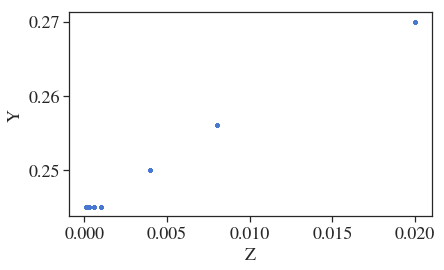

In [7]:
plt.plot(DF['Z'], DF['Y'], '.')
plt.xlabel('Z')
plt.ylabel('Y')
plt.show()

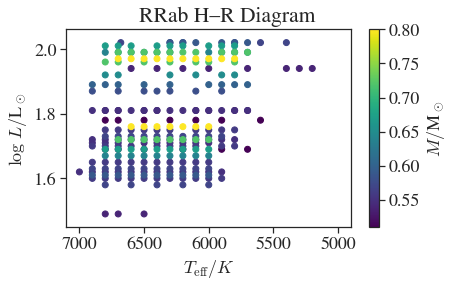

In [8]:
plt.suptitle('RRab H–R Diagram', y=0.99)
plt.scatter(DF['Teff'], DF['logL'], c=DF['M'], cmap='viridis')
plt.xlabel('$T_{\mathrm{eff}}/K$')
plt.ylabel('$\log\;L/$L$_\odot$')
plt.colorbar(label='$M/$M$_\odot$')
plt.xlim([7100, 4900])

plt.savefig('RRL-HR.pdf', bbox_inches='tight')
plt.show()

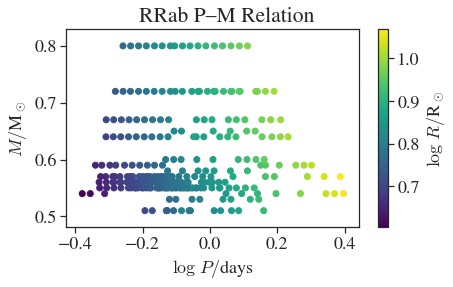

In [9]:
plt.suptitle('RRab P–M Relation', y=0.99)
plt.scatter(DF['logP'], DF['M'], c=DF['logR'], cmap='viridis')
plt.xlabel('$\log\;P/$days')
plt.ylabel('$M/$M$_\odot$')
plt.colorbar(label='$\log\;R/$R$_\odot$')

plt.savefig('RRL-PMR.pdf', bbox_inches='tight')
plt.show()

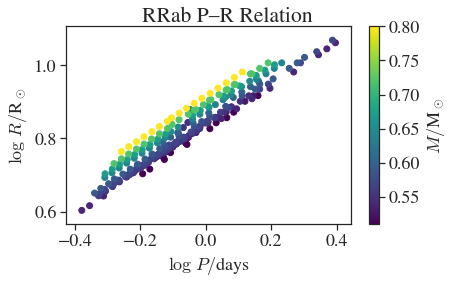

In [10]:
plt.suptitle('RRab P–R Relation')
plt.scatter(DF['logP'], DF['logR'], c=DF['M'], cmap='viridis')
plt.ylabel('$\log\;R/$R$_\odot$')
plt.xlabel('$\log\;P/$days')
plt.colorbar(label='$M/$M$_\odot$')

plt.savefig('RRL-PRM.pdf', bbox_inches='tight')
plt.show()

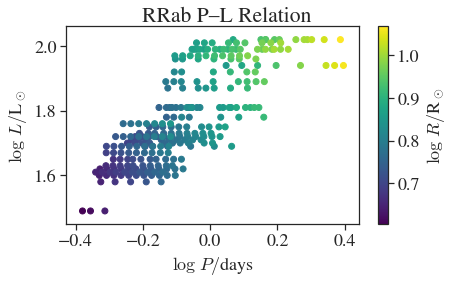

In [11]:
plt.suptitle('RRab P–L Relation')
plt.scatter(DF['logP'], DF['logL'], c=DF['logR'], cmap='viridis')
plt.ylabel('$\log\;L/$L$_\odot$')
plt.xlabel('$\log\;P/$days')
plt.colorbar(label='$\log\;R/$R$_\odot$')

plt.savefig('PL.pdf', bbox_inches='tight')
plt.show()

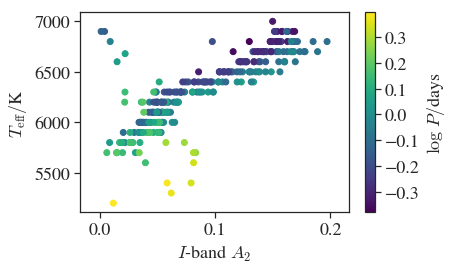

In [12]:
plt.scatter(DF['I_A2'], DF['Teff'], c=DF['logP'])
plt.xlabel('$I$-band $A_2$')
plt.ylabel('$T_{\\rm{eff}}/$K')
plt.colorbar(label='$\log\;P/$days')

plt.savefig('A2Teff.pdf', bbox_inches='tight')
plt.show()

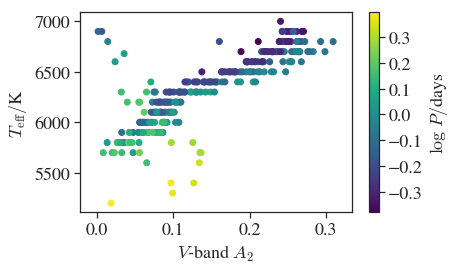

In [13]:
plt.scatter(DF['V_A2'], DF['Teff'], c=DF['logP'])
plt.xlabel('$V$-band $A_2$')
plt.ylabel('$T_{\\rm{eff}}/$K')
plt.colorbar(label='$\log\;P/$days')

plt.show()

Leave-one-out cross validation

In [14]:
## Leave-one-out cross validation with multi-target outputs 

ml = TransformedTargetRegressor(regressor=Pipeline(
            [('scaler', RobustScaler()), 
             ('mlp', MLPRegressor(hidden_layer_sizes=(100, 100), 
                                  max_iter=2000, activation='relu', solver='lbfgs', tol=1e-7))]),
         transformer=RobustScaler())
lm = LinearRegression()

ml_pred = []
lm_pred = []

for ii in tqdm(range(DF.shape[0])):
    ml.fit(DF.drop(ii)[y_columns], DF.drop(ii)[X_columns])
    ml_pred += [ml.predict(DF.iloc[ii][y_columns].values.reshape(1, -1))[0]]
    
    lm.fit(DF.drop(ii)[['logP']],  DF.drop(ii)[X_columns])
    lm_pred += [lm.predict(DF.iloc[ii]['logP'].reshape(1, -1))[0]]

ml_pred = np.array(ml_pred)
lm_pred = np.array(lm_pred)

In [15]:
np.savetxt('NN_loo_cv-ml_pred-RRL.dat', ml_pred)
np.savetxt('LM_loo_cv-lm_pred-RRL.dat', lm_pred)

In [16]:
ml_pred   = np.loadtxt('NN_loo_cv-ml_pred-RRL.dat')
lm_pred   = np.loadtxt('LM_loo_cv-lm_pred-RRL.dat')

Compute R^2 and standard deviations

In [17]:
all_r2s = []
all_sds = []

for pred in (ml_pred, lm_pred):
    
    r2s = []
    sds = []
    
    for idx, name in enumerate(X_columns):
        std = np.array(np.array(pred[:,idx]) - DF[name]).std()
        sds += [std]
        
        SS_tot = np.sum((DF[name] - DF[name].mean())**2)
        SS_res = np.sum((pred[:,idx] - DF[name].values)**2)
        R2 = 1-SS_res/SS_tot
        
        r2s += [R2]
    
    all_r2s += [r2s]
    all_sds += [sds]

all_r2s = np.array(all_r2s)
all_sds = np.array(all_sds)

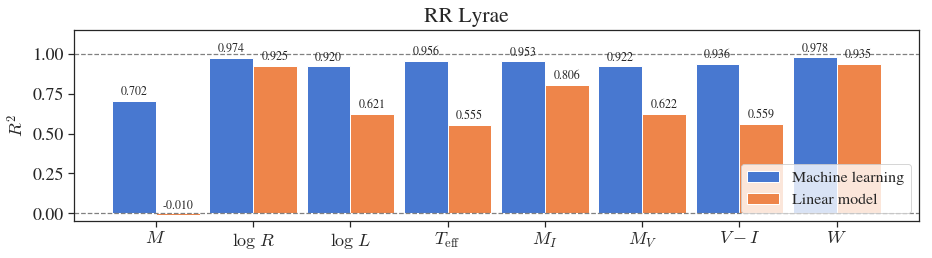

In [18]:
labels = ['$M$', '$\log\;R$', '$\log\;L$', '$T_{\\rm{eff}}$', '$M_I$', '$M_V$', '$V-I$', '$W$']#, 'Y', 'Z']

plt.rcParams["font.size"] = 18
x = np.arange(len(labels))  # the label locations
width = 0.45  # the width of the bars

fig, ax = plt.subplots(figsize=(6.64306*2,4.10318716*0.9))
plt.suptitle('RR Lyrae', y=0.99)
rects1 = ax.bar(x - width/2, all_r2s[0,:], width, label='Machine learning')
rects2 = ax.bar(x + width/2, all_r2s[1,:], width, label='Linear model')

plt.axhline(1, c='gray', linewidth=1.25, linestyle='--')
plt.axhline(0, c='gray', linewidth=1.25, linestyle='--')

ax.set_ylabel('$R^2$')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_ylim([-0.05, 1.15])
ax.legend(loc='lower right')

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('%.3f' % height,
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

plt.rcParams["font.size"] = 12
autolabel(rects1)
autolabel(rects2)
plt.rcParams["font.size"] = 18
#autolabel(rects3)

plt.savefig('RRL-R2-ML-LM.pdf')
plt.show()

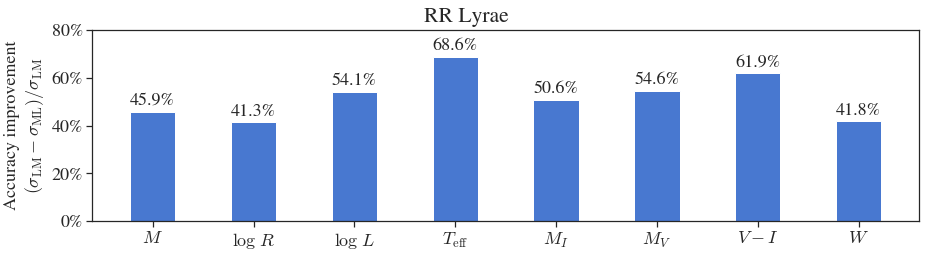

In [19]:
labels = ['$M$', '$\log\;R$', '$\log\;L$', '$T_{\\rm{eff}}$', '$M_I$', '$M_V$', '$V-I$', '$W$']#, 'Y', 'Z']

x = np.arange(len(labels))
width = 0.45

fig, ax = plt.subplots(figsize=(6.64306*2,4.10318716*0.9))
plt.suptitle('RR Lyrae', y=0.99)
rects1 = ax.bar(x, (all_sds[1,:] - all_sds[0,:])/all_sds[1,:], width)

ax.set_ylabel('Accuracy improvement\n$(\sigma_{\\rm{LM}} - \sigma_{\\rm{ML}}) / \sigma_{\\rm{LM}}$')
ax.set_xticks(x)
ax.set_xticklabels(labels)

ax.set_ylim([0, 0.8])
ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8])
locs, labels = plt.yticks()
ax.set_yticklabels([str(int(loc*100)) + '%' for loc in locs])

def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('%.1f' % (height*100) + '%',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3), 
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)

plt.savefig('RRL-sds-ML-LM.pdf')
plt.show()

In [20]:
ml_stds = []
ml_r2s = []

for idx, name in enumerate(X_columns):
    std = np.array(np.array(ml_pred[:,idx]) - DF[name]).std()
    print(name, 'std: %.3f' % std)
    ml_stds += [std]
    
    SS_tot = np.sum((DF[name] - DF[name].mean())**2)
    SS_res = np.sum((ml_pred[:,idx] - DF[name].values)**2)
    R2 = 1-SS_res/SS_tot
    ml_r2s += [R2]
    
    print(name, 'R2: %.3f' % R2)

M std: 0.042
M R2: 0.702
logR std: 0.016
logR R2: 0.974
logL std: 0.040
logL R2: 0.920
Teff std: 75.128
Teff R2: 0.956
I_M0 std: 0.080
I_M0 R2: 0.953
V_M0 std: 0.094
V_M0 R2: 0.922
VI std: 0.021
VI R2: 0.936
W std: 0.066
W R2: 0.978


In [21]:
lm_stds = []
lm_r2s = []

for idx, name in enumerate(X_columns):
    std = np.array(np.array(lm_pred[:,idx]) - DF[name]).std()
    print(name, 'std: %.3f' % std)
    lm_stds += [std]
    
    SS_tot = np.sum((DF[name] - DF[name].mean())**2)
    SS_res = np.sum((lm_pred[:,idx] - DF[name].values)**2)
    R2 = 1-SS_res/SS_tot
    lm_r2s += [R2]
    
    print(name, 'R2: %.3f' % R2)

M std: 0.077
M R2: -0.010
logR std: 0.027
logR R2: 0.925
logL std: 0.087
logL R2: 0.621
Teff std: 239.608
Teff R2: 0.555
I_M0 std: 0.162
I_M0 R2: 0.806
V_M0 std: 0.207
V_M0 R2: 0.622
VI std: 0.056
VI R2: 0.559
W std: 0.113
W R2: 0.935


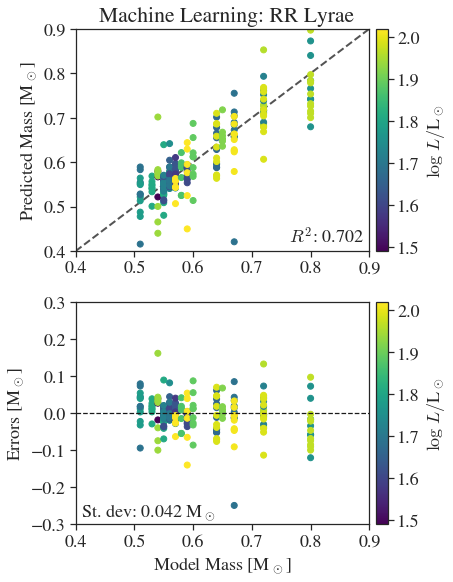

In [22]:
var = 'M'
lims = [0.4, 0.9]

plt.figure(figsize=(6.64306,4.10318716*2))
plt.suptitle('Machine Learning: RR Lyrae', y=0.995)

ax = plt.subplot(2,1,1)
plt.scatter(DF[var], ml_pred[:,X_columns.index(var)], c=DF['logL'])
plt.plot([lims[0],lims[1]], [lims[0],lims[1]], 'k--', alpha=0.75, zorder=0)
plt.ylabel('Predicted Mass [M$_\odot$]')
plt.xlim(lims)
plt.ylim(lims)
plt.colorbar(label='$\log\;L/$L$_\odot$', pad=0.02)
plt.text(0.764, 0.42, '$R^2$: %.3f' % ml_r2s[X_columns.index(var)])

ax2 = plt.subplot(2,1,2, sharex=ax)
plt.axhline(0, c='k', ls='--', linewidth=1.25)
plt.scatter(DF[var], ml_pred[:,X_columns.index(var)] - DF[var], c=DF['logL'])
plt.xlabel('Model Mass [M$_\odot$]')
plt.ylabel('Errors [M$_\odot$]')
plt.colorbar(label='$\log\;L/$L$_\odot$', pad=0.02)
plt.xlim(lims)
plt.ylim([-0.3, 0.3])
plt.text(0.41, -0.28, 'St. dev: %.3f M$_\odot$' % ml_stds[X_columns.index(var)])

plt.savefig('RRL-ML-mass.pdf')#, bbox_inches='tight')
plt.show()

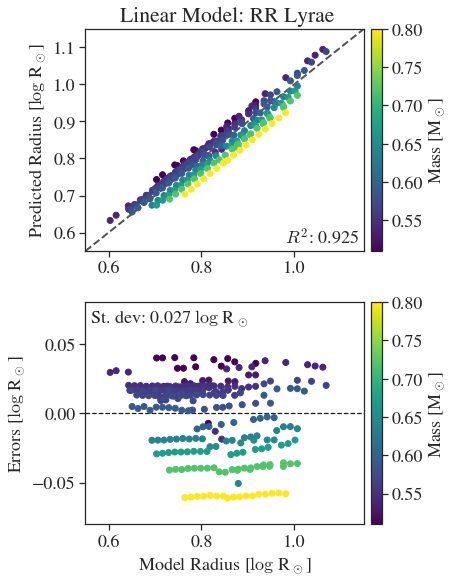

In [23]:
var = 'logR'
lims = [0.55, 1.15]

fig = plt.figure(figsize=(6.64306,4.10318716*2))
plt.suptitle('Linear Model: RR Lyrae', y=0.995)

ax = plt.subplot(2,1,1)
plt.scatter(DF[var], lm_pred[:,X_columns.index(var)], c=DF['M'])
plt.plot([lims[0],lims[1]], [lims[0],lims[1]], 'k--', alpha=0.75, zorder=0)
plt.ylabel('Predicted Radius [$\log$ R$_\odot$]')
plt.xlim(lims)
plt.ylim(lims)
plt.colorbar(label='Mass [M$_\odot$]', pad=0.02)
plt.text(0.98, 0.572, '$R^2$: %.3f' % lm_r2s[X_columns.index(var)])

ax2 = plt.subplot(2,1,2, sharex=ax)
plt.plot([lims[0], lims[1]], [0, 0], 'k--', zorder=0, linewidth=1.25)
plt.scatter(DF[var], lm_pred[:,X_columns.index(var)] - DF[var], c=DF['M'])
plt.colorbar(label='Mass [M$_\odot$]', pad=0.02)
plt.xlabel('Model Radius [$\log$ R$_\odot$]')
plt.ylabel('Errors [$\log$ R$_\odot$]')
plt.xlim(lims)
plt.ylim([-0.08, 0.08])
plt.text(0.56, 0.065, 'St. dev: %.3f $\log$ R$_\odot$' % lm_stds[X_columns.index(var)])

plt.savefig('RRL-LM-radius.pdf')#, bbox_inches='tight')
plt.show()

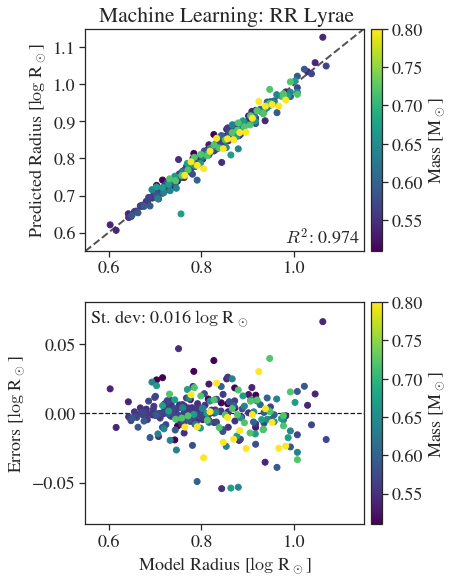

In [24]:
var = 'logR'
lims = [0.55, 1.15]

plt.figure(figsize=(6.64306,4.10318716*2))
plt.suptitle('Machine Learning: RR Lyrae', y=0.995)

ax = plt.subplot(2,1,1)
plt.scatter(DF[var], ml_pred[:,X_columns.index(var)], c=DF['M'])
plt.plot([lims[0],lims[1]], [lims[0],lims[1]], 'k--', alpha=0.75, zorder=0)
plt.ylabel('Predicted Radius [$\log$ R$_\odot$]')
plt.xlim(lims)
plt.ylim(lims)
plt.colorbar(label='Mass [M$_\odot$]', pad=0.02)
plt.text(0.98, 0.572, '$R^2$: %.3f' % ml_r2s[X_columns.index(var)])

ax2 = plt.subplot(2,1,2, sharex=ax)
plt.plot([lims[0], lims[1]], [0, 0], 'k--', zorder=0, linewidth=1.25)
plt.scatter(DF[var], ml_pred[:,X_columns.index(var)] - DF[var], c=DF['M'])
plt.colorbar(label='Mass [M$_\odot$]', pad=0.02)
plt.xlabel('Model Radius [$\log$ R$_\odot$]')
plt.ylabel('Errors [$\log$ R$_\odot$]')
plt.xlim(lims)
plt.ylim([-0.08, 0.08])
plt.text(0.56, 0.065, 'St. dev: %.3f $\log$ R$_\odot$' % ml_stds[X_columns.index(var)])

plt.savefig('RRL-ML-radius.pdf')#, bbox_inches='tight')
plt.show()

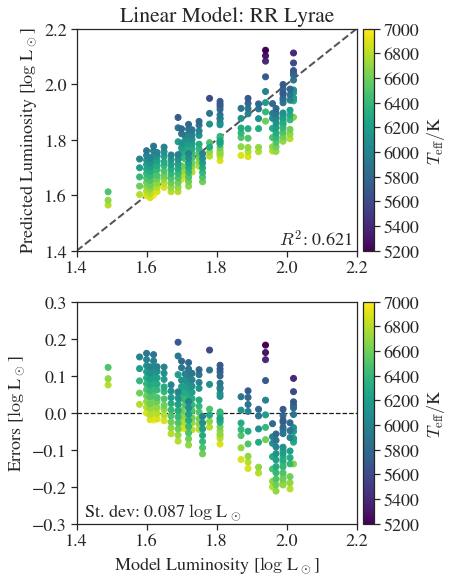

In [25]:
var = 'logL'
lims = [1.4, 2.2]

fig = plt.figure(figsize=(6.64306,4.10318716*2))
plt.suptitle('Linear Model: RR Lyrae', y=0.995)

ax = plt.subplot(2,1,1)
plt.scatter(DF[var], lm_pred[:,X_columns.index(var)], c=DF['Teff'])
plt.plot([lims[0],lims[1]], [lims[0],lims[1]], 'k--', alpha=0.75, zorder=0)
plt.ylabel('Predicted Luminosity [$\log$ L$_\odot$]')
plt.xlim(lims)
plt.ylim(lims)
plt.colorbar(label='$T_{\\rm{eff}}/$K', pad=0.02)
plt.text(1.978, 1.42, '$R^2$: %.3f' % lm_r2s[X_columns.index(var)])

ax2 = plt.subplot(2,1,2, sharex=ax)
plt.plot([lims[0], lims[1]], [0, 0], 'k--', zorder=0, linewidth=1.25)
plt.scatter(DF['logL'], lm_pred[:,X_columns.index(var)] - DF['logL'], c=DF['Teff'])
plt.colorbar(label='$T_{\\rm{eff}}/$K', pad=0.02)
plt.xlabel('Model Luminosity [$\log$ L$_\odot$]')
plt.ylabel('Errors [$\log$ L$_\odot$]')
plt.xlim(lims)
plt.ylim([-0.3, 0.3])
plt.text(1.42, -0.28, 'St. dev: %.3f $\log$ L$_\odot$' % lm_stds[X_columns.index(var)])

plt.savefig('RRL-LM-luminosity.pdf')#, bbox_inches='tight')
plt.show()

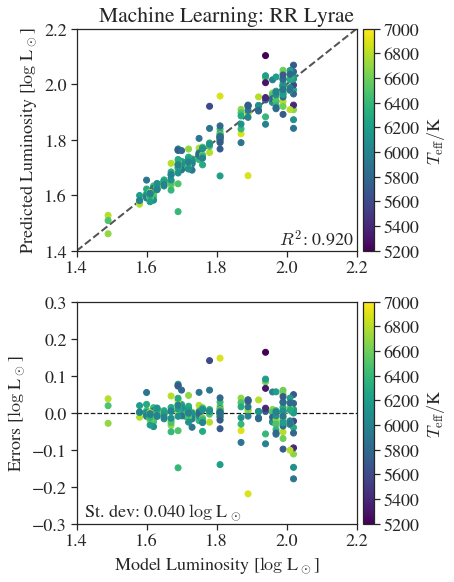

In [26]:
var = 'logL'
lims = [1.4, 2.2]

plt.figure(figsize=(6.64306,4.10318716*2))
plt.suptitle('Machine Learning: RR Lyrae', y=0.995)

ax = plt.subplot(2,1,1)
plt.scatter(DF[var], ml_pred[:,X_columns.index(var)], c=DF['Teff'])
plt.plot([lims[0],lims[1]], [lims[0],lims[1]], 'k--', alpha=0.75, zorder=0)
plt.ylabel('Predicted Luminosity [$\log$ L$_\odot$]')
plt.xlim(lims)
plt.ylim(lims)
plt.colorbar(label='$T_{\\rm{eff}}/$K', pad=0.02)
plt.text(1.978, 1.42, '$R^2$: %.3f' % ml_r2s[X_columns.index(var)])

ax2 = plt.subplot(2,1,2, sharex=ax)
plt.plot([lims[0], lims[1]], [0, 0], 'k--', zorder=0, linewidth=1.25)
plt.scatter(DF['logL'], ml_pred[:,X_columns.index(var)] - DF['logL'], c=DF['Teff'])
plt.colorbar(label='$T_{\\rm{eff}}/$K', pad=0.02)
plt.xlabel('Model Luminosity [$\log$ L$_\odot$]')
plt.ylabel('Errors [$\log$ L$_\odot$]')
plt.xlim(lims)
plt.ylim([-0.3, 0.3])
plt.text(1.42, -0.28, 'St. dev: %.3f $\log$ L$_\odot$' % ml_stds[X_columns.index(var)])

plt.savefig('RRL-ML-luminosity.pdf')#, bbox_inches='tight')
plt.show()

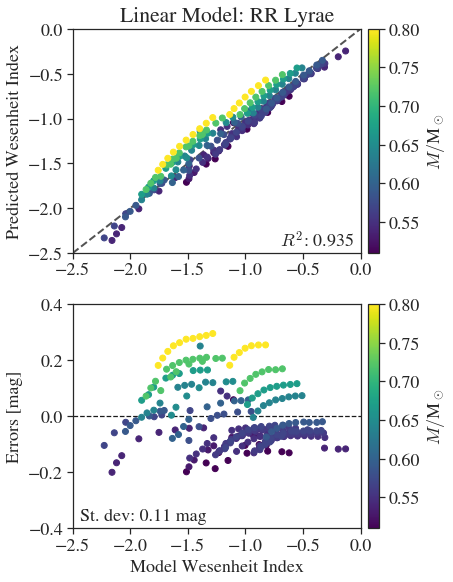

In [27]:
var = 'W'
lims = [-2.5, 0]

fig = plt.figure(figsize=(6.64306,4.10318716*2))
plt.suptitle('Linear Model: RR Lyrae', y=0.995)

ax = plt.subplot(2,1,1)
plt.scatter(DF[var], lm_pred[:,X_columns.index(var)], c=DF['M'])
plt.plot([lims[0],lims[1]], [lims[0],lims[1]], 'k--', alpha=0.75, zorder=0)
plt.ylabel('Predicted Wesenheit Index')
plt.xlim(lims)
plt.ylim(lims)
plt.colorbar(label='$M/$M$_\odot$', pad=0.02)
plt.text(-0.7, -2.42, '$R^2$: %.3f' % lm_r2s[X_columns.index(var)])

ax2 = plt.subplot(2,1,2, sharex=ax)
plt.plot([lims[0], lims[1]], [0, 0], 'k--', zorder=0, linewidth=1.25)
plt.scatter(DF[var], lm_pred[:,X_columns.index(var)] - DF[var], c=DF['M'])
plt.colorbar(label='$M/$M$_\odot$', pad=0.02)
plt.xlabel('Model Wesenheit Index')
plt.ylabel('Errors [mag]')
plt.xlim(lims)
plt.ylim([-0.4, 0.4])
plt.text(-2.44, -0.37, 'St. dev: %.2f mag' % lm_stds[X_columns.index(var)])

plt.savefig('RRL-LM-W.pdf')#, bbox_inches='tight')
plt.show()

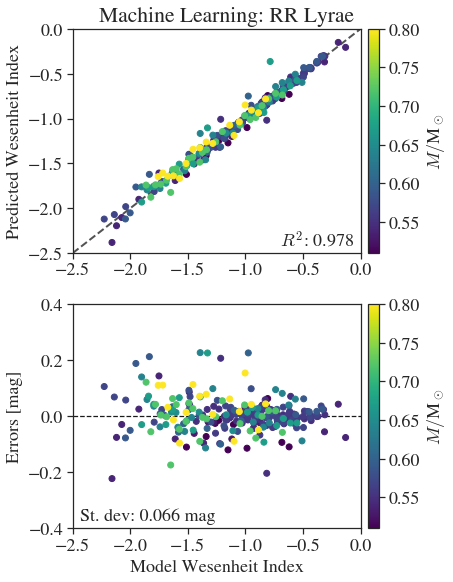

In [28]:
var = 'W'
lims = [-2.5, 0]

plt.figure(figsize=(6.64306,4.10318716*2))
plt.suptitle('Machine Learning: RR Lyrae', y=0.995)

ax = plt.subplot(2,1,1)
plt.scatter(DF[var], ml_pred[:,X_columns.index(var)], c=DF['M'])
plt.plot([lims[0],lims[1]], [lims[0],lims[1]], 'k--', alpha=0.75, zorder=0)
plt.ylabel('Predicted Wesenheit Index')
plt.xlim(lims)
plt.ylim(lims)
plt.colorbar(label='$M/$M$_\odot$', pad=0.02)
plt.text(-0.7, -2.42, '$R^2$: %.3f' % ml_r2s[X_columns.index(var)])

ax2 = plt.subplot(2,1,2, sharex=ax)
plt.plot([lims[0], lims[1]], [0, 0], 'k--', zorder=0, linewidth=1.25)
plt.scatter(DF[var], ml_pred[:,X_columns.index(var)] - DF[var], c=DF['M'])
plt.colorbar(label='$M/$M$_\odot$', pad=0.02)
plt.xlabel('Model Wesenheit Index')
plt.ylabel('Errors [mag]')
plt.xlim(lims)
plt.ylim([-0.4, 0.4])
plt.text(-2.44, -0.37, 'St. dev: %.3f mag' % ml_stds[X_columns.index(var)])

plt.savefig('RRL-ML-W.pdf')#, bbox_inches='tight')
plt.show()

Significance testing

In [29]:
np.random.seed(0) 

ml = TransformedTargetRegressor(regressor=Pipeline(
            [('scaler', RobustScaler()), 
             ('mlp', MLPRegressor(hidden_layer_sizes=(100, 100), 
                                  max_iter=2000, activation='relu', solver='lbfgs', tol=1e-7))]),
         transformer=RobustScaler())
lm = LinearRegression()

first_p1 = 0 
s2s = []

for ii in range(5):
    ml_scores = []
    lm_scores = []
    
    cv = ShuffleSplit(n_splits=2, random_state=ii, train_size=0.5, test_size=0.5)
    
    for train_index, test_index in cv.split(DF):
        ml.fit(DF.iloc[train_index][y_columns], DF.iloc[train_index][X_columns])
        lm.fit(DF.iloc[train_index][['logP']],  DF.iloc[train_index][X_columns])
        
        ml_predict = ml.predict(DF.iloc[test_index][y_columns])
        lm_predict = lm.predict(DF.iloc[test_index][['logP']])
        
        ml_scores_ = []
        lm_scores_ = []
        
        for idx, name in enumerate(X_columns):
            SS_tot = np.sum((DF.iloc[test_index][name] - DF.iloc[test_index][name].mean())**2)
            
            ml_SS_res = np.sum((ml_predict[:,idx] - DF.iloc[test_index][name].values)**2)
            ml_R2 = 1-ml_SS_res/SS_tot
            ml_scores_ += [ml_R2]
            
            lm_SS_res = np.sum((lm_predict[:,idx] - DF.iloc[test_index][name].values)**2)
            lm_R2 = 1-lm_SS_res/SS_tot
            lm_scores_ += [lm_R2]
        
        ml_scores += [ml_scores_]
        lm_scores += [lm_scores_]
    
    ml_scores = np.array(ml_scores)
    lm_scores = np.array(lm_scores)
    
    p1 = ml_scores[0,:] - lm_scores[0,:]
    p2 = ml_scores[1,:] - lm_scores[1,:]
    p_bar = (p1 + p2)/2
    s2 = (p1 - p_bar)**2 + (p2 - p_bar)**2
    
    if ii == 0:
        first_p1 = p1
    s2s += [s2]

first_p1 = np.array(first_p1)
s2s = np.array(s2s)

for idx, name in enumerate(X_columns):
    p = stats.t.sf(np.abs(first_p1[idx]) / np.sqrt(1/5. * sum(s2s[:,idx])), 5)*2.
    print(name, '%.10f' % p)

M 0.0016754200
logR 0.0008064740
logL 0.0003150405
Teff 0.0000037544
I_M0 0.0002786049
V_M0 0.0002939848
VI 0.0000804828
W 0.0006372976


Now train on all models and run on real data 

In [30]:
np.random.seed(0) 

ml = TransformedTargetRegressor(regressor=Pipeline(
            [('scaler', RobustScaler()), 
             ('mlp', MLPRegressor(hidden_layer_sizes=(100, 100), 
                                  max_iter=2000, activation='relu', solver='lbfgs', tol=1e-7))]),
         transformer=RobustScaler())
lm = LinearRegression()

ml.fit(DF[y_columns], DF[X_columns])
lm.fit(DF[['logP']], DF[X_columns])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [31]:
maxs = DF[y_columns].quantile(0.95)
mins = DF[y_columns].quantile(0.05)
#print(maxs, mins)

In [32]:
X_maxs = DF[X_columns].max()#quantile(0.95)
X_mins = DF[X_columns].min()#quantile(0.05)
#print(X_maxs, X_mins)

In [33]:
RRL_SMC_I = pd.read_table('/scratch/seismo/bellinger/asteroseismology/regression/classical/data/rrl_smc_i.dat', sep='\s+')
RRL_SMC_V = pd.read_table('/scratch/seismo/bellinger/asteroseismology/regression/classical/data/rrl_smc_v.dat', sep='\s+')
RRL_LMC_I = pd.read_table('/scratch/seismo/bellinger/asteroseismology/regression/classical/data/rrl_lmc_i.dat', sep='\s+')
RRL_LMC_V = pd.read_table('/scratch/seismo/bellinger/asteroseismology/regression/classical/data/rrl_lmc_v.dat', sep='\s+')
RRL_BLG_I = pd.read_table('/scratch/seismo/bellinger/asteroseismology/regression/classical/data/rrl_blg_i.dat', sep='\s+')
RRL_BLG_V = pd.read_table('/scratch/seismo/bellinger/asteroseismology/regression/classical/data/rrl_blg_v.dat', sep='\s+')

In [34]:
RRL_SMC_I

,ID,Period,rms,Amplitude,Fe_H,Skewness,acuteness,R21,R31,Phi21,Phi31,A0,A1,Phi1,A2,Phi2,A3,Phi3,eR21,eR31,ePhi21,ePhi31,eA0,eA1,ePhi1,eA2,ePhi2,eA3,ePhi3
0,OGLE-SMC-RRLYR-0001,0.55881,0.05005,0.647,-1.47868,5.17973,1.74725,0.43399,0.32042,2.64703,5.34299,19.06259,0.22284,3.89977,0.09671,4.16338,0.07140,4.47592,0.01348,0.01326,0.00383,0.00600,0.00199,0.00265,0.00265,0.00277,0.00277,0.00283,0.00283
1,OGLE-SMC-RRLYR-0002,0.59479,0.05025,0.390,-1.21418,3.88199,1.05146,0.41802,0.31414,2.88643,5.87803,19.00946,0.14329,3.92149,0.05990,4.44623,0.04501,5.07614,0.01830,0.01762,0.00338,0.00528,0.00168,0.00235,0.00235,0.00243,0.00243,0.00241,0.00241
2,OGLE-SMC-RRLYR-0003,0.65068,0.06082,0.278,-1.24799,2.32783,1.13513,0.30742,0.12629,2.91025,6.16947,19.15828,0.12136,3.07346,0.03731,2.77399,0.01533,2.82349,0.02065,0.02037,0.00339,0.00540,0.00172,0.00241,0.00241,0.00239,0.00239,0.00245,0.00245
3,OGLE-SMC-RRLYR-0005,0.56527,0.10520,0.461,-1.43464,1.97929,1.87572,0.39412,0.17869,2.57736,5.43482,19.05841,0.17870,3.94683,0.07043,4.18784,0.03193,4.70895,0.01603,0.01437,0.00371,0.00573,0.00185,0.00257,0.00257,0.00268,0.00268,0.00253,0.00253
4,OGLE-SMC-RRLYR-0006,0.54718,0.06006,0.687,-1.50173,5.15788,1.86802,0.44964,0.35210,2.68027,5.24583,19.01223,0.23245,3.76519,0.10452,3.92747,0.08185,3.97502,0.01274,0.01236,0.00379,0.00594,0.00191,0.00264,0.00264,0.00271,0.00271,0.00272,0.00272
5,OGLE-SMC-RRLYR-0008,0.63288,0.05785,0.343,-1.16613,3.53282,1.00803,0.40800,0.26330,2.92141,6.16291,19.15441,0.13104,3.77496,0.05347,4.18813,0.03450,4.92141,0.01958,0.01860,0.00343,0.00550,0.00170,0.00249,0.00249,0.00236,0.00236,0.00235,0.00235
6,OGLE-SMC-RRLYR-0009,0.69476,0.05595,0.535,-1.62741,4.51817,1.00059,0.49840,0.36094,2.93988,5.97125,18.89076,0.17805,3.67685,0.08874,4.01039,0.06426,4.43543,0.02171,0.02137,0.00492,0.00788,0.00248,0.00351,0.00351,0.00345,0.00345,0.00359,0.00359
7,OGLE-SMC-RRLYR-0010,0.55303,0.05833,0.382,-1.25050,3.74616,1.29412,0.28358,0.20355,2.79883,5.58548,19.25850,0.17012,3.92814,0.04824,4.37194,0.03463,4.80354,0.01988,0.01987,0.00458,0.00724,0.00229,0.00322,0.00322,0.00326,0.00326,0.00332,0.00332
8,OGLE-SMC-RRLYR-0011,0.59576,0.06516,0.428,-1.35983,4.48171,1.37558,0.37925,0.29230,2.65410,5.70704,19.16784,0.16384,4.29020,0.06214,4.95131,0.04789,6.01126,0.01746,0.01756,0.00380,0.00608,0.00194,0.00271,0.00271,0.00267,0.00267,0.00277,0.00277
9,OGLE-SMC-RRLYR-0012,0.62563,0.05894,0.436,-1.25887,4.09938,1.11146,0.37288,0.32937,2.82694,6.00726,19.19334,0.16219,3.59886,0.06048,3.74148,0.05342,4.23747,0.01725,0.01647,0.00367,0.00572,0.00182,0.00256,0.00256,0.00263,0.00263,0.00253,0.00253


In [35]:
np.random.seed(0)

n_perturb = 100

star_names = []
ests = []
e_ests = []
logPs = []

lm_ests = []
e_lm_ests = []

actual_Ws = []
e_actual_Ws = []
actual_Is = []
actual_Vs = []
actual_VIs = []

for idx, star in tqdm(RRL_SMC_I.iterrows(), total=RRL_SMC_I.shape[0]):
    
    star_name = star['ID']
    
    V_data = RRL_SMC_V[RRL_SMC_V['ID'] == star_name]
    
    if V_data.shape[0] == 0:
        continue 
    
    logP = np.log10(star['Period'])
    I_Amplitude = star['Amplitude']
    I_Skewness  = star['Skewness']
    I_acuteness = star['acuteness']
    I_A1 = star['A1']
    I_A2 = star['A2']
    I_A3 = star['A3']
    
    e_I_A1 = star['eA1']
    e_I_A2 = star['eA2']
    e_I_A3 = star['eA3']
    
    V_Amplitude = V_data['Amplitude']
    V_Skewness  = V_data['Skewness']
    V_acuteness = V_data['acuteness']
    V_A1 = V_data['A1']
    V_A2 = V_data['A2']
    V_A3 = V_data['A3']
    
    e_V_A1 = V_data['eA1']
    e_V_A2 = V_data['eA2']
    e_V_A3 = V_data['eA3']
    
    star_data = pd.DataFrame({'logP':        np.repeat(logP,        n_perturb), 
                              'I_Amplitude': np.repeat(I_Amplitude, n_perturb),
                              'I_Skewness':  np.repeat(I_Skewness,  n_perturb),
                              'I_acuteness': np.repeat(I_acuteness, n_perturb),
                              'V_Amplitude': np.repeat(V_Amplitude, n_perturb),
                              'V_Skewness':  np.repeat(V_Skewness,  n_perturb),
                              'V_acuteness': np.repeat(V_acuteness, n_perturb),
                              'I_A1':        np.random.normal(loc=I_A1, scale=e_I_A1, size=n_perturb),
                              'I_A2':        np.random.normal(loc=I_A2, scale=e_I_A2, size=n_perturb),
                              'I_A3':        np.random.normal(loc=I_A3, scale=e_I_A3, size=n_perturb),
                              'V_A1':        np.random.normal(loc=V_A1, scale=e_V_A1, size=n_perturb),
                              'V_A2':        np.random.normal(loc=V_A2, scale=e_V_A2, size=n_perturb),
                              'V_A3':        np.random.normal(loc=V_A3, scale=e_V_A3, size=n_perturb)})
    
    
    if np.any(star_data[y_columns] >= maxs) or np.any(star_data[y_columns] <= mins):
        continue 
    
    res = ml.predict(star_data[y_columns])
    
    if np.any([res_i >= X_maxs for res_i in res]) or \
       np.any([res_i <= X_mins for res_i in res]):
        continue
    
    ests += [res[0]]
    e_ests += [res.std(axis=0)]
    
    lm_res = lm.predict(star_data[['logP']])
    lm_ests += [lm_res[0]]
    e_lm_ests += [lm_res.std(axis=0)]
    
    star_names += [star_name]
    logPs += [star_data['logP'].iloc[0]]
    
    V = V_data['A0']
    I = star['A0']
    W = I - 1.55 * (V-I)
    actual_Ws += [W.values[0]]
    
    #if idx > 100:
    #    break

SMC_star_names = star_names
SMC_logPs = np.array(logPs)
SMC_ests = np.array(ests)
SMC_e_ests = np.array(e_ests)
SMC_actual_Ws = np.array(actual_Ws)
lm_ests = np.array(lm_ests)
e_lm_ests = np.array(e_lm_ests)

In [36]:
np.random.seed(0)

n_perturb = 100

star_names = []
ests = []
e_ests = []
logPs = []

lm_ests = []
e_lm_ests = []

actual_Ws = []
e_actual_Ws = []
actual_Is = []
actual_Vs = []
actual_VIs = []

for idx, star in tqdm(RRL_LMC_I.iterrows(), total=RRL_LMC_I.shape[0]):
    
    star_name = star['ID']
    
    V_data = RRL_LMC_V[RRL_LMC_V['ID'] == star_name]
    
    if V_data.shape[0] == 0:
        continue 
    
    logP = np.log10(star['Period'])
    I_Amplitude = star['Amplitude']
    I_Skewness  = star['Skewness']
    I_acuteness = star['acuteness']
    I_A1 = star['A1']
    I_A2 = star['A2']
    I_A3 = star['A3']
    
    e_I_A1 = star['eA1']
    e_I_A2 = star['eA2']
    e_I_A3 = star['eA3']
    
    V_Amplitude = V_data['Amplitude']
    V_Skewness  = V_data['Skewness']
    V_acuteness = V_data['acuteness']
    V_A1 = V_data['A1']
    V_A2 = V_data['A2']
    V_A3 = V_data['A3']
    
    e_V_A1 = V_data['eA1']
    e_V_A2 = V_data['eA2']
    e_V_A3 = V_data['eA3']
    
    star_data = pd.DataFrame({'logP':        np.repeat(logP,        n_perturb), 
                              'I_Amplitude': np.repeat(I_Amplitude, n_perturb),
                              'I_Skewness':  np.repeat(I_Skewness,  n_perturb),
                              'I_acuteness': np.repeat(I_acuteness, n_perturb),
                              'V_Amplitude': np.repeat(V_Amplitude, n_perturb),
                              'V_Skewness':  np.repeat(V_Skewness,  n_perturb),
                              'V_acuteness': np.repeat(V_acuteness, n_perturb),
                              'I_A1':        np.random.normal(loc=I_A1, scale=e_I_A1, size=n_perturb),
                              'I_A2':        np.random.normal(loc=I_A2, scale=e_I_A2, size=n_perturb),
                              'I_A3':        np.random.normal(loc=I_A3, scale=e_I_A3, size=n_perturb),
                              'V_A1':        np.random.normal(loc=V_A1, scale=e_V_A1, size=n_perturb),
                              'V_A2':        np.random.normal(loc=V_A2, scale=e_V_A2, size=n_perturb),
                              'V_A3':        np.random.normal(loc=V_A3, scale=e_V_A3, size=n_perturb)})
    
    
    if np.any(star_data[y_columns] >= maxs) or np.any(star_data[y_columns] <= mins):
        continue 
    
    res = ml.predict(star_data[y_columns])
    
    if np.any([res_i >= X_maxs for res_i in res]) or \
       np.any([res_i <= X_mins for res_i in res]):
        continue
    
    ests += [res[0]]
    e_ests += [res.std(axis=0)]
    
    lm_res = lm.predict(star_data[['logP']])
    lm_ests += [lm_res[0]]
    e_lm_ests += [lm_res.std(axis=0)]
    
    star_names += [star_name]
    logPs += [star_data['logP'].iloc[0]]
    
    V = V_data['A0']
    I = star['A0']
    W = I - 1.55 * (V-I)
    actual_Ws += [W.values[0]]
    
    #if idx > 100:
    #    break

LMC_star_names = star_names
LMC_logPs = np.array(logPs)
LMC_ests = np.array(ests)
LMC_e_ests = np.array(e_ests)
LMC_actual_Ws = np.array(actual_Ws)
lm_ests = np.array(lm_ests)
e_lm_ests = np.array(e_lm_ests)

In [37]:
np.random.seed(0)

n_perturb = 100

star_names = []
ests = []
e_ests = []
logPs = []

lm_ests = []
e_lm_ests = []

actual_Ws = []
e_actual_Ws = []
actual_Is = []
actual_Vs = []
actual_VIs = []

for idx, star in tqdm(RRL_BLG_I.iterrows(), total=RRL_BLG_I.shape[0]):
    
    star_name = star['ID']
    
    V_data = RRL_BLG_V[RRL_BLG_V['ID'] == star_name]
    
    if V_data.shape[0] == 0:
        continue 
    
    logP = np.log10(star['Period'])
    I_Amplitude = star['Amplitude']
    I_Skewness  = star['Skewness']
    I_acuteness = star['acuteness']
    I_A1 = star['A1']
    I_A2 = star['A2']
    I_A3 = star['A3']
    
    e_I_A1 = star['eA1']
    e_I_A2 = star['eA2']
    e_I_A3 = star['eA3']
    
    V_Amplitude = V_data['Amplitude']
    V_Skewness  = V_data['Skewness']
    V_acuteness = V_data['acuteness']
    V_A1 = V_data['A1']
    V_A2 = V_data['A2']
    V_A3 = V_data['A3']
    
    e_V_A1 = V_data['eA1']
    e_V_A2 = V_data['eA2']
    e_V_A3 = V_data['eA3']
    
    star_data = pd.DataFrame({'logP':        np.repeat(logP,        n_perturb), 
                              'I_Amplitude': np.repeat(I_Amplitude, n_perturb),
                              'I_Skewness':  np.repeat(I_Skewness,  n_perturb),
                              'I_acuteness': np.repeat(I_acuteness, n_perturb),
                              'V_Amplitude': np.repeat(V_Amplitude, n_perturb),
                              'V_Skewness':  np.repeat(V_Skewness,  n_perturb),
                              'V_acuteness': np.repeat(V_acuteness, n_perturb),
                              'I_A1':        np.random.normal(loc=I_A1, scale=e_I_A1, size=n_perturb),
                              'I_A2':        np.random.normal(loc=I_A2, scale=e_I_A2, size=n_perturb),
                              'I_A3':        np.random.normal(loc=I_A3, scale=e_I_A3, size=n_perturb),
                              'V_A1':        np.random.normal(loc=V_A1, scale=e_V_A1, size=n_perturb),
                              'V_A2':        np.random.normal(loc=V_A2, scale=e_V_A2, size=n_perturb),
                              'V_A3':        np.random.normal(loc=V_A3, scale=e_V_A3, size=n_perturb)})
    
    
    if np.any(star_data[y_columns] >= maxs) or np.any(star_data[y_columns] <= mins):
        continue 
    
    res = ml.predict(star_data[y_columns])
    
    if np.any([res_i >= X_maxs for res_i in res]) or \
       np.any([res_i <= X_mins for res_i in res]):
        continue
    
    ests += [res[0]]
    e_ests += [res.std(axis=0)]
    
    lm_res = lm.predict(star_data[['logP']])
    lm_ests += [lm_res[0]]
    e_lm_ests += [lm_res.std(axis=0)]
    
    star_names += [star_name]
    logPs += [star_data['logP'].iloc[0]]
    
    V = V_data['A0']
    I = star['A0']
    W = I - 1.55 * (V-I)
    actual_Is += [I]
    actual_Vs += [V]
    actual_VIs += [V-I]
    actual_Ws += [W.values[0]]
    
    #if idx > 100:
    #    break

BLG_star_names = star_names
BLG_logPs = np.array(logPs)
BLG_ests = np.array(ests)
BLG_e_ests = np.array(e_ests)
BLG_actual_Ws = np.array(actual_Ws)
lm_ests = np.array(lm_ests)
e_lm_ests = np.array(e_lm_ests)

In [38]:
SMC_e_ests_ = np.array([np.sqrt(SMC_e_ests[ii]**2 + np.array(ml_stds)**2) 
                    for ii in range(len(SMC_e_ests))])
LMC_e_ests_ = np.array([np.sqrt(LMC_e_ests[ii]**2 + np.array(ml_stds)**2) 
                    for ii in range(len(LMC_e_ests))])
BLG_e_ests_ = np.array([np.sqrt(BLG_e_ests[ii]**2 + np.array(ml_stds)**2) 
                    for ii in range(len(BLG_e_ests))])

In [39]:
np.savetxt('RRL-SMC-periods.dat',       SMC_logPs)
np.savetxt('RRL-SMC-estimates.dat',     SMC_ests)
np.savetxt('RRL-SMC-uncertainties.dat', SMC_e_ests_)
np.savetxt('RRL-LMC-periods.dat',       LMC_logPs)
np.savetxt('RRL-LMC-estimates.dat',     LMC_ests)
np.savetxt('RRL-LMC-uncertainties.dat', LMC_e_ests_)
np.savetxt('RRL-BLG-periods.dat',       BLG_logPs)
np.savetxt('RRL-BLG-estimates.dat',     BLG_ests)
np.savetxt('RRL-BLG-uncertainties.dat', BLG_e_ests_)

In [40]:
SMC_logPs   = np.loadtxt('RRL-SMC-periods.dat')
SMC_ests    = np.loadtxt('RRL-SMC-estimates.dat')
SMC_e_ests_ = np.loadtxt('RRL-SMC-uncertainties.dat')
LMC_logPs   = np.loadtxt('RRL-LMC-periods.dat')
LMC_ests    = np.loadtxt('RRL-LMC-estimates.dat')
LMC_e_ests_ = np.loadtxt('RRL-LMC-uncertainties.dat')
BLG_logPs   = np.loadtxt('RRL-BLG-periods.dat')
BLG_ests    = np.loadtxt('RRL-BLG-estimates.dat')
BLG_e_ests_ = np.loadtxt('RRL-BLG-uncertainties.dat')

Produce catalogs

In [41]:
def signif(x, digits=6):
    if x == 0 or not isfinite(x):
        return x
    digits -= ceil(log10(abs(x)))
    rounded = round(x, digits)
    if rounded > 10:
        rounded = int(rounded)
    return rounded

def formatter(val, unc):
    unc = str(signif(unc, 2))
    if len(unc) == 1:
        unc += '.0'
    if float(unc) < 10:
        if unc[-2] == '0' or (unc[-2] == '.' and unc[-3] == '0'):
            unc += '0'
        dec_places = len(unc.split('.')[1])
        val = str(val).split('.')
        val = val[0] + '.' + val[1][:dec_places]
    else:
        val = str(val).split('.')[0]
        if len(unc) > 2:
            val = val[:len(val) - len(unc) + 2] + '0'*(len(val) - len(unc))
    return [val, unc]

In [42]:
# SMC

ests = SMC_ests
e_ests_ = SMC_e_ests_
star_names = SMC_star_names

ests_ = np.vstack(chain.from_iterable(((ests[:,ii], e_ests_[:,ii]) for ii in range(ests.shape[1])))).T
ests_DF = pd.DataFrame(ests_, columns=list(chain.from_iterable(zip(X_columns, ['e_'+X_col for X_col in X_columns]))))
ests_DF.insert(0, 'ID', star_names)

for index, row in ests_DF.iloc[0:10].iterrows():
    out_str = row['ID'].split('-')[-1]
    
    rest = row[1:]
    for ii in range(len(rest) - 1):
        if ii % 2 != 0: # every other column contains the uncertainty 
            continue
        
        val, unc = formatter(rest[ii], rest[ii+1])
        out_str += ' & ' + val + ' $\pm$ ' + unc
    
    out_str += r' \\'
    
    print(out_str)

0001 & 0.595 $\pm$ 0.051 & 0.708 $\pm$ 0.018 & 1.661 $\pm$ 0.041 & 6642 $\pm$ 84 & 0.142 $\pm$ 0.083 & 0.653 $\pm$ 0.096 & 0.490 $\pm$ 0.023 & -0.613 $\pm$ 0.072 \\
0002 & 0.581 $\pm$ 0.047 & 0.709 $\pm$ 0.018 & 1.604 $\pm$ 0.042 & 6429 $\pm$ 83 & 0.277 $\pm$ 0.083 & 0.798 $\pm$ 0.097 & 0.532 $\pm$ 0.023 & -0.560 $\pm$ 0.071 \\
0003 & 0.648 $\pm$ 0.043 & 0.755 $\pm$ 0.016 & 1.723 $\pm$ 0.043 & 6574 $\pm$ 85 & -0.006 $\pm$ 0.085 & 0.48 $\pm$ 0.10 & 0.484 $\pm$ 0.024 & -0.754 $\pm$ 0.068 \\
0008 & 0.697 $\pm$ 0.043 & 0.767 $\pm$ 0.016 & 1.675 $\pm$ 0.041 & 6274 $\pm$ 78 & 0.096 $\pm$ 0.081 & 0.657 $\pm$ 0.095 & 0.569 $\pm$ 0.022 & -0.791 $\pm$ 0.067 \\
0009 & 0.683 $\pm$ 0.047 & 0.785 $\pm$ 0.018 & 1.769 $\pm$ 0.041 & 6475 $\pm$ 84 & -0.110 $\pm$ 0.082 & 0.418 $\pm$ 0.095 & 0.529 $\pm$ 0.023 & -0.933 $\pm$ 0.073 \\
0011 & 0.669 $\pm$ 0.044 & 0.742 $\pm$ 0.017 & 1.697 $\pm$ 0.041 & 6534 $\pm$ 81 & 0.097 $\pm$ 0.081 & 0.601 $\pm$ 0.095 & 0.508 $\pm$ 0.022 & -0.695 $\pm$ 0.069 \\
0012 & 0.6

In [43]:
out_str = '\t'.join(list(ests_DF.columns)) + '\n'
for index, row in ests_DF.iterrows():
    out_str += row['ID'] + '\t'
    
    rest = row[1:]
    for ii in range(len(rest) - 1):
        if ii % 2 != 0: # every other column contains the uncertainty 
            continue
        
        val, unc = formatter(rest[ii], rest[ii+1])
        out_str += val + '\t' + unc + '\t'
    
    out_str += '\n'
    
print(out_str)

out_file = open("ML-OGLE_SMC_RRL.dat", "w")
out_file.write(out_str)
out_file.close()

ID	M	e_M	logR	e_logR	logL	e_logL	Teff	e_Teff	I_M0	e_I_M0	V_M0	e_V_M0	VI	e_VI	W	e_W
OGLE-SMC-RRLYR-0001	0.595	0.051	0.708	0.018	1.661	0.041	6642	84	0.142	0.083	0.653	0.096	0.490	0.023	-0.613	0.072	
OGLE-SMC-RRLYR-0002	0.581	0.047	0.709	0.018	1.604	0.042	6429	83	0.277	0.083	0.798	0.097	0.532	0.023	-0.560	0.071	
OGLE-SMC-RRLYR-0003	0.648	0.043	0.755	0.016	1.723	0.043	6574	85	-0.006	0.085	0.48	0.10	0.484	0.024	-0.754	0.068	
OGLE-SMC-RRLYR-0008	0.697	0.043	0.767	0.016	1.675	0.041	6274	78	0.096	0.081	0.657	0.095	0.569	0.022	-0.791	0.067	
OGLE-SMC-RRLYR-0009	0.683	0.047	0.785	0.018	1.769	0.041	6475	84	-0.110	0.082	0.418	0.095	0.529	0.023	-0.933	0.073	
OGLE-SMC-RRLYR-0011	0.669	0.044	0.742	0.017	1.697	0.041	6534	81	0.097	0.081	0.601	0.095	0.508	0.022	-0.695	0.069	
OGLE-SMC-RRLYR-0012	0.689	0.044	0.758	0.016	1.709	0.040	6457	79	0.049	0.080	0.571	0.094	0.527	0.022	-0.774	0.068	
OGLE-SMC-RRLYR-0015	0.637	0.052	0.730	0.019	1.687	0.042	6574	90	0.106	0.083	0.598	0.098	0.500	0.024	-0.672	0.075	
OGLE-

In [44]:
# LMC

ests = LMC_ests
e_ests_ = LMC_e_ests_
star_names = LMC_star_names

ests_ = np.vstack(chain.from_iterable(((ests[:,ii], e_ests_[:,ii]) for ii in range(ests.shape[1])))).T
ests_DF = pd.DataFrame(ests_, columns=list(chain.from_iterable(zip(X_columns, ['e_'+X_col for X_col in X_columns]))))
ests_DF.insert(0, 'ID', star_names)

for index, row in ests_DF.iloc[0:10].iterrows():
    out_str = row['ID'].split('-')[-1]
    
    rest = row[1:]
    for ii in range(len(rest) - 1):
        if ii % 2 != 0: # every other column contains the uncertainty 
            continue
        
        val, unc = formatter(rest[ii], rest[ii+1])
        out_str += ' & ' + val + ' $\pm$ ' + unc
    
    out_str += r' \\'
    
    print(out_str)

00008 & 0.605 $\pm$ 0.048 & 0.787 $\pm$ 0.019 & 1.778 $\pm$ 0.043 & 6490 $\pm$ 92 & -0.164 $\pm$ 0.085 & 0.334 $\pm$ 0.098 & 0.508 $\pm$ 0.025 & -0.964 $\pm$ 0.076 \\
00010 & 0.676 $\pm$ 0.052 & 0.746 $\pm$ 0.019 & 1.667 $\pm$ 0.043 & 6389 $\pm$ 91 & 0.140 $\pm$ 0.085 & 0.677 $\pm$ 0.098 & 0.542 $\pm$ 0.025 & -0.714 $\pm$ 0.078 \\
00027 & 0.714 $\pm$ 0.050 & 0.843 $\pm$ 0.020 & 1.828 $\pm$ 0.043 & 6272 $\pm$ 89 & -0.284 $\pm$ 0.087 & 0.27 $\pm$ 0.10 & 0.567 $\pm$ 0.025 & -1.166 $\pm$ 0.080 \\
00040 & 0.676 $\pm$ 0.049 & 0.757 $\pm$ 0.018 & 1.665 $\pm$ 0.044 & 6311 $\pm$ 88 & 0.135 $\pm$ 0.086 & 0.68 $\pm$ 0.10 & 0.560 $\pm$ 0.025 & -0.748 $\pm$ 0.075 \\
00072 & 0.693 $\pm$ 0.049 & 0.767 $\pm$ 0.019 & 1.698 $\pm$ 0.044 & 6367 $\pm$ 88 & 0.061 $\pm$ 0.086 & 0.59 $\pm$ 0.10 & 0.546 $\pm$ 0.024 & -0.791 $\pm$ 0.074 \\
00079 & 0.623 $\pm$ 0.048 & 0.715 $\pm$ 0.018 & 1.660 $\pm$ 0.042 & 6592 $\pm$ 86 & 0.185 $\pm$ 0.085 & 0.681 $\pm$ 0.099 & 0.498 $\pm$ 0.024 & -0.591 $\pm$ 0.073 \\
00082 & 

In [45]:
out_str = '\t'.join(list(ests_DF.columns)) + '\n'
for index, row in ests_DF.iterrows():
    out_str += row['ID'] + '\t'
    
    rest = row[1:]
    for ii in range(len(rest) - 1):
        if ii % 2 != 0: # every other column contains the uncertainty 
            continue
        
        val, unc = formatter(rest[ii], rest[ii+1])
        out_str += val + '\t' + unc + '\t'
    
    out_str += '\n'
    
print(out_str)

out_file = open("ML-OGLE_LMC_RRL.dat", "w")
out_file.write(out_str)
out_file.close()

ID	M	e_M	logR	e_logR	logL	e_logL	Teff	e_Teff	I_M0	e_I_M0	V_M0	e_V_M0	VI	e_VI	W	e_W
OGLE-LMC-RRLYR-00008	0.605	0.048	0.787	0.019	1.778	0.043	6490	92	-0.164	0.085	0.334	0.098	0.508	0.025	-0.964	0.076	
OGLE-LMC-RRLYR-00010	0.676	0.052	0.746	0.019	1.667	0.043	6389	91	0.140	0.085	0.677	0.098	0.542	0.025	-0.714	0.078	
OGLE-LMC-RRLYR-00027	0.714	0.050	0.843	0.020	1.828	0.043	6272	89	-0.284	0.087	0.27	0.10	0.567	0.025	-1.166	0.080	
OGLE-LMC-RRLYR-00040	0.676	0.049	0.757	0.018	1.665	0.044	6311	88	0.135	0.086	0.68	0.10	0.560	0.025	-0.748	0.075	
OGLE-LMC-RRLYR-00072	0.693	0.049	0.767	0.019	1.698	0.044	6367	88	0.061	0.086	0.59	0.10	0.546	0.024	-0.791	0.074	
OGLE-LMC-RRLYR-00079	0.623	0.048	0.715	0.018	1.660	0.042	6592	86	0.185	0.085	0.681	0.099	0.498	0.024	-0.591	0.073	
OGLE-LMC-RRLYR-00082	0.665	0.052	0.729	0.018	1.715	0.042	6693	85	0.071	0.082	0.559	0.096	0.478	0.024	-0.669	0.073	
OGLE-LMC-RRLYR-00103	0.653	0.055	0.752	0.020	1.696	0.043	6451	90	0.076	0.085	0.608	0.096	0.529	0.024	-0.744	0.080	
O

In [46]:
# BLG

ests = BLG_ests
e_ests_ = BLG_e_ests_
star_names = BLG_star_names

ests_ = np.vstack(chain.from_iterable(((ests[:,ii], e_ests_[:,ii]) for ii in range(ests.shape[1])))).T
ests_DF = pd.DataFrame(ests_, columns=list(chain.from_iterable(zip(X_columns, ['e_'+X_col for X_col in X_columns]))))
ests_DF.insert(0, 'ID', star_names)

for index, row in ests_DF.iloc[0:10].iterrows():
    out_str = row['ID'].split('-')[-1]
    
    rest = row[1:]
    for ii in range(len(rest) - 1):
        if ii % 2 != 0: # every other column contains the uncertainty 
            continue
        
        val, unc = formatter(rest[ii], rest[ii+1])
        out_str += ' & ' + val + ' $\pm$ ' + unc
    
    out_str += r' \\'
    
    print(out_str)

00197 & 0.728 $\pm$ 0.048 & 0.756 $\pm$ 0.018 & 1.661 $\pm$ 0.041 & 6300 $\pm$ 83 & 0.136 $\pm$ 0.083 & 0.708 $\pm$ 0.096 & 0.570 $\pm$ 0.023 & -0.742 $\pm$ 0.072 \\
00207 & 0.567 $\pm$ 0.045 & 0.669 $\pm$ 0.016 & 1.603 $\pm$ 0.041 & 6733 $\pm$ 80 & 0.308 $\pm$ 0.082 & 0.784 $\pm$ 0.096 & 0.470 $\pm$ 0.022 & -0.423 $\pm$ 0.068 \\
00236 & 0.579 $\pm$ 0.043 & 0.717 $\pm$ 0.016 & 1.722 $\pm$ 0.040 & 6818 $\pm$ 79 & 0.044 $\pm$ 0.080 & 0.500 $\pm$ 0.095 & 0.450 $\pm$ 0.022 & -0.656 $\pm$ 0.067 \\
00242 & 0.630 $\pm$ 0.049 & 0.718 $\pm$ 0.018 & 1.621 $\pm$ 0.042 & 6419 $\pm$ 81 & 0.233 $\pm$ 0.082 & 0.770 $\pm$ 0.097 & 0.539 $\pm$ 0.023 & -0.609 $\pm$ 0.070 \\
00254 & 0.539 $\pm$ 0.046 & 0.675 $\pm$ 0.017 & 1.605 $\pm$ 0.042 & 6707 $\pm$ 84 & 0.283 $\pm$ 0.082 & 0.773 $\pm$ 0.097 & 0.478 $\pm$ 0.023 & -0.456 $\pm$ 0.069 \\
00276 & 0.645 $\pm$ 0.052 & 0.705 $\pm$ 0.019 & 1.654 $\pm$ 0.042 & 6637 $\pm$ 82 & 0.195 $\pm$ 0.083 & 0.677 $\pm$ 0.096 & 0.488 $\pm$ 0.023 & -0.564 $\pm$ 0.073 \\
0039

In [47]:
out_str = '\t'.join(list(ests_DF.columns)) + '\n'
for index, row in ests_DF.iterrows():
    out_str += row['ID'] + '\t'
    
    rest = row[1:]
    for ii in range(len(rest) - 1):
        if ii % 2 != 0: # every other column contains the uncertainty 
            continue
        
        val, unc = formatter(rest[ii], rest[ii+1])
        out_str += val + '\t' + unc + '\t'
    
    out_str += '\n'
    
print(out_str)

out_file = open("ML-OGLE_BLG_RRL.dat", "w")
out_file.write(out_str)
out_file.close()

ID	M	e_M	logR	e_logR	logL	e_logL	Teff	e_Teff	I_M0	e_I_M0	V_M0	e_V_M0	VI	e_VI	W	e_W
OGLE-BLG-RRLYR-00197	0.728	0.048	0.756	0.018	1.661	0.041	6300	83	0.136	0.083	0.708	0.096	0.570	0.023	-0.742	0.072	
OGLE-BLG-RRLYR-00207	0.567	0.045	0.669	0.016	1.603	0.041	6733	80	0.308	0.082	0.784	0.096	0.470	0.022	-0.423	0.068	
OGLE-BLG-RRLYR-00236	0.579	0.043	0.717	0.016	1.722	0.040	6818	79	0.044	0.080	0.500	0.095	0.450	0.022	-0.656	0.067	
OGLE-BLG-RRLYR-00242	0.630	0.049	0.718	0.018	1.621	0.042	6419	81	0.233	0.082	0.770	0.097	0.539	0.023	-0.609	0.070	
OGLE-BLG-RRLYR-00254	0.539	0.046	0.675	0.017	1.605	0.042	6707	84	0.283	0.082	0.773	0.097	0.478	0.023	-0.456	0.069	
OGLE-BLG-RRLYR-00276	0.645	0.052	0.705	0.019	1.654	0.042	6637	82	0.195	0.083	0.677	0.096	0.488	0.023	-0.564	0.073	
OGLE-BLG-RRLYR-00397	0.569	0.047	0.679	0.017	1.633	0.041	6760	81	0.243	0.082	0.710	0.095	0.461	0.023	-0.473	0.070	
OGLE-BLG-RRLYR-00409	0.691	0.046	0.757	0.017	1.691	0.042	6385	83	0.080	0.082	0.607	0.098	0.540	0.023	-0.763	0.07

Visualize the RR Lyraes in the three galaxies

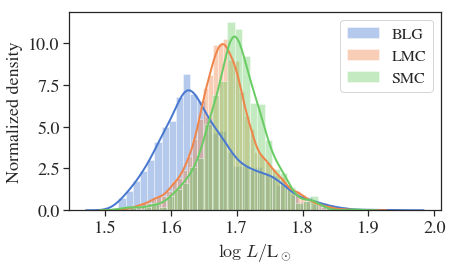

In [48]:
sns.distplot(BLG_ests[:,X_columns.index('logL')], label='BLG')
sns.distplot(LMC_ests[:,X_columns.index('logL')], label='LMC')
sns.distplot(SMC_ests[:,X_columns.index('logL')], label='SMC')
plt.xlabel('$\log\;L/$L$_\odot$')
plt.ylabel('Normalized density')
plt.legend(loc='best')
plt.savefig('RRL-luminosity-distributions.pdf', bbox_inches='tight')
plt.show()

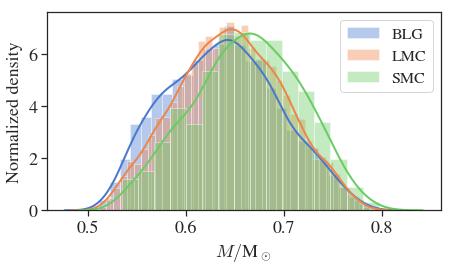

In [49]:
sns.distplot(BLG_ests[:,X_columns.index('M')], label='BLG')
sns.distplot(LMC_ests[:,X_columns.index('M')], label='LMC')
sns.distplot(SMC_ests[:,X_columns.index('M')], label='SMC')
plt.xlabel('$M/$M$_\odot$')
plt.ylabel('Normalized density')
plt.legend(loc='best')
plt.savefig('RRL-mass-distributions.pdf', bbox_inches='tight')
plt.show()

In [50]:
print(SMC_ests.shape[0], LMC_ests.shape[0], BLG_ests.shape[0])

812 9238 3504


Estimate distances

18.526503225305543 +/- 0.14558343129721593


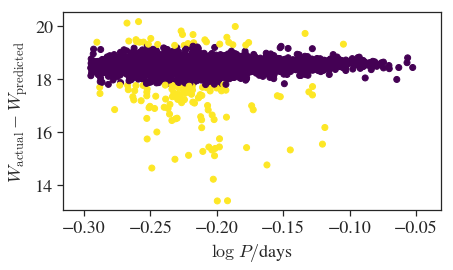

In [51]:
inliers = [True for ii in range(len(LMC_actual_Ws))]
while True:
    values = np.array(LMC_actual_Ws - LMC_ests[:,X_columns.index('W')])
    weights = 1. / LMC_e_ests_[:,X_columns.index('W')]**2
    
    average = np.average(values[inliers], weights=weights[inliers])
    variance = np.average((values-average)[inliers]**2, weights=weights[inliers])
    
    new_outliers = np.abs(values[inliers] - average)/np.sqrt(variance) > 5
    if not np.any(new_outliers):
        break
    inliers = np.logical_not(np.abs(values - average)/np.sqrt(variance) > 5)

print(average, '+/-', np.sqrt(variance))

plt.scatter(LMC_logPs, LMC_actual_Ws - LMC_ests[:,X_columns.index('W')], c=np.logical_not(inliers))

plt.xlabel('$\log\;P/$days')
plt.ylabel('$W_{\\rm{actual}} - W_{\\rm{predicted}}$')
plt.show()

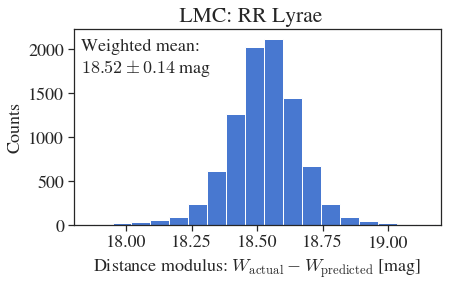

In [52]:
plt.suptitle('         LMC: RR Lyrae', y=0.99)
plt.hist(np.array(LMC_actual_Ws - LMC_ests[:,X_columns.index('W')])[inliers], bins=20)
plt.xlabel('Distance modulus: $W_{\\rm{actual}} - W_{\\rm{predicted}}$ [mag]')
plt.ylabel('Counts')
plt.xlim([17.8, 19.2])
plt.text(17.83, 1720, 'Weighted mean:\n$18.52 \pm 0.14$ mag')

plt.savefig('LMC-RRL-distance_modulus_hist.pdf')
plt.show()

18.88943507366791 +/- 0.17551737207951196


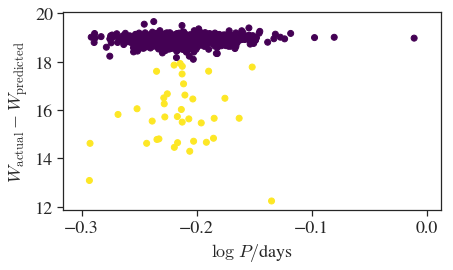

In [53]:
inliers = [True for ii in range(len(SMC_actual_Ws))]
while True:
    values = np.array(SMC_actual_Ws - SMC_ests[:,X_columns.index('W')])
    weights = 1. / SMC_e_ests_[:,X_columns.index('W')]**2
    
    average = np.average(values[inliers], weights=weights[inliers])
    variance = np.average((values-average)[inliers]**2, weights=weights[inliers])
    
    new_outliers = np.abs(values[inliers] - average)/np.sqrt(variance) > 5
    if not np.any(new_outliers):
        break
    inliers = np.logical_not(np.abs(values - average)/np.sqrt(variance) > 5)

print(average, '+/-', np.sqrt(variance))

plt.scatter(SMC_logPs, SMC_actual_Ws - SMC_ests[:,X_columns.index('W')], c=np.logical_not(inliers))

plt.xlabel('$\log\;P/$days')
plt.ylabel('$W_{\\rm{actual}} - W_{\\rm{predicted}}$')
plt.show()

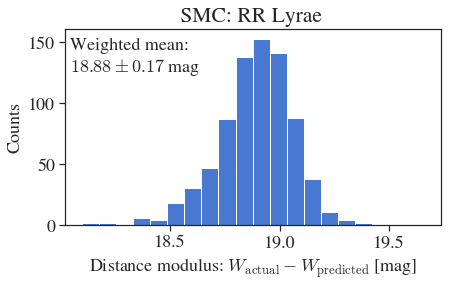

In [54]:
plt.suptitle('         SMC: RR Lyrae', y=0.99)
plt.hist(np.array(SMC_actual_Ws - SMC_ests[:,X_columns.index('W')])[inliers], bins=20)
plt.xlabel('Distance modulus: $W_{\\rm{actual}} - W_{\\rm{predicted}}$ [mag]')
plt.ylabel('Counts')
#plt.xlim([17.8, 19.2])
plt.text(18.04, 125, 'Weighted mean:\n$18.88 \pm 0.17$ mag')

plt.savefig('SMC-RRL-distance_modulus_hist.pdf')
plt.show()

Use random forests to obtain feature importances 

In [55]:
y_col_names = ['$\log\;P$', 
               '$I$ Amplitude', '$I$ Skewness', '$I$ Acuteness',
               '$V$ Amplitude', '$V$ Skewness', '$V$ Acuteness',
               '$I$ $A_1$', '$I$ $A_2$', '$I$ $A_3$',
               '$V$ $A_1$', '$V$ $A_2$', '$V$ $A_3$']

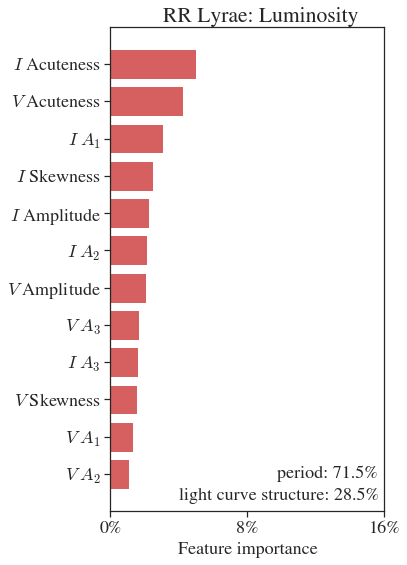

In [56]:
rf = RandomForestRegressor(n_estimators=1024, random_state=1)
X = DF[y_columns]
rf.fit(X, DF['logL'])

importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)
indices = np.argsort(importances)

plt.figure(figsize=(6,8))
plt.suptitle('                     RR Lyrae: Luminosity', y=0.99)
rects1 = plt.barh(range(X.shape[1])[:-1], importances[indices][:-1],
       color="r", align="center")
plt.yticks(range(X.shape[1])[:-1], [y_col_names[idx] for idx in indices][:-1])
plt.ylim([-1, X.shape[1]-1])
plt.xlabel('Feature importance')

plt.xlim([0, 0.16])
ax = plt.gca()
ax.set_xticks([0, 0.08, 0.16])
ax.set_xticklabels(['0%', '8%', '16%'])

plt.text(0.0972, -0.1, 'period: %.1f%%' % (importances[0]*100))
plt.text(0.04,   -0.7, 'light curve structure: %.1f%%' % (sum(importances[1:])*100))

def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('%.1f' % (height*100) + '%',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3), 
                    textcoords="offset points",
                    ha='center', va='bottom')

plt.savefig('RRL-L-importances.pdf')
plt.show()

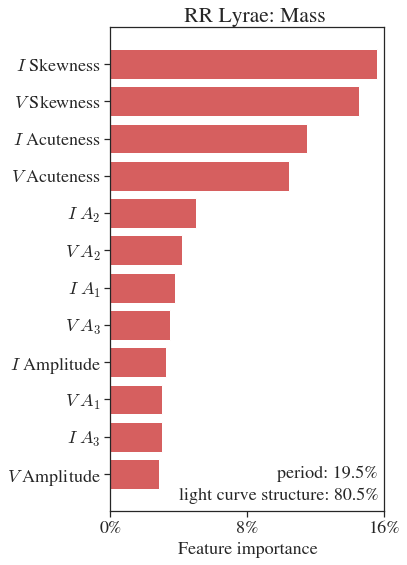

In [57]:
rf = RandomForestRegressor(n_estimators=1024, random_state=1)
X = DF[y_columns]
rf.fit(X, DF['M'])

importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)
indices = np.argsort(importances)

plt.figure(figsize=(6,8))
plt.suptitle('                   RR Lyrae: Mass', y=0.99)
rects1 = plt.barh(range(X.shape[1])[:-1], importances[indices][:-1],
       color="r", align="center")
plt.yticks(range(X.shape[1])[:-1], [y_col_names[idx] for idx in indices][:-1])#, rotation='vertical')
plt.ylim([-1, X.shape[1]-1])
plt.xlabel('Feature importance')

plt.xlim([0, 0.16])
ax = plt.gca()
ax.set_xticks([0, 0.08, 0.16])
ax.set_xticklabels(['0%', '8%', '16%'])

plt.text(0.0972, -0.1, 'period: %.1f%%' % (importances[0]*100))
plt.text(0.04,   -0.7, 'light curve structure: %.1f%%' % (sum(importances[1:])*100))

def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('%.1f' % (height*100) + '%',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3), 
                    textcoords="offset points",
                    ha='center', va='bottom')

plt.savefig('RRL-M-importances.pdf')
plt.show()

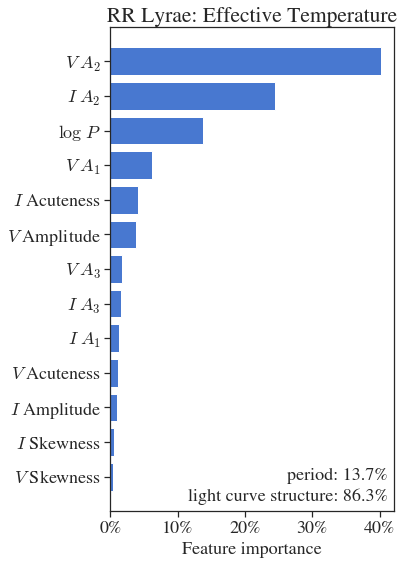

In [58]:
rf = RandomForestRegressor(n_estimators=1024, random_state=1)
X = DF[y_columns]
rf.fit(X, DF['Teff'])

importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)
indices = np.argsort(importances)

plt.figure(figsize=(6,8))
plt.suptitle('                  RR Lyrae: Effective Temperature', y=0.99)
rects1 = plt.barh(range(X.shape[1]), importances[indices],
       color="b", align="center")
plt.yticks(range(X.shape[1]), [y_col_names[idx] for idx in indices])
plt.ylim([-1, X.shape[1]])
plt.xlabel('Feature importance')

#plt.xlim([0, 0.25])
ax = plt.gca()
ax.set_xticks([0, 0.1, 0.2, 0.3, 0.4])
ax.set_xticklabels(['0%', '10%', '20%', '30%', '40%'])
plt.text(0.263,-0.1,    'period: %.1f%%' % (importances[0]*100))
plt.text(0.115, -0.7, 'light curve structure: %.1f%%' % (sum(importances[1:])*100))

def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('%.1f' % (height*100) + '%',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3), 
                    textcoords="offset points",
                    ha='center', va='bottom')

plt.savefig('RRL-Teff-importances.pdf')
plt.show()

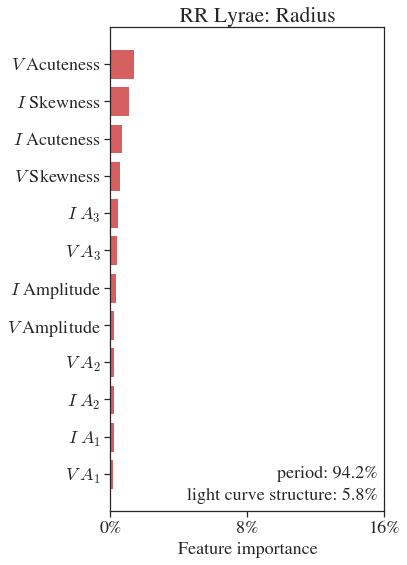

In [59]:
rf = RandomForestRegressor(n_estimators=1024, random_state=1)
X = DF[y_columns]
rf.fit(X, DF['logR'])

importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)
indices = np.argsort(importances)

plt.figure(figsize=(6,8))
plt.suptitle('                    RR Lyrae: Radius', y=0.99)
rects1 = plt.barh(range(X.shape[1])[:-1], importances[indices][:-1],
       color="r", #yerr=std[indices][1:], 
                  align="center")
plt.yticks(range(X.shape[1])[:-1], [y_col_names[idx] for idx in indices][:-1])#, rotation='vertical')
plt.ylim([-1, X.shape[1]-1])
plt.xlabel('Feature importance')

plt.xlim([0, 0.16])
ax = plt.gca()
ax.set_xticks([0, 0.08, 0.16])
ax.set_xticklabels(['0%', '8%', '16%'])

plt.text(0.0972, -0.1, 'period: %.1f%%' % (importances[0]*100))
plt.text(0.045,   -0.7, 'light curve structure: %.1f%%' % (sum(importances[1:])*100))

def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('%.1f' % (height*100) + '%',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3), 
                    textcoords="offset points",
                    ha='center', va='bottom')

plt.savefig('RRL-logR-importances.pdf')
plt.show()